In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, LabelEncoder, RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, KFold

import lightgbm

from pycaret.classification import *

from sklearn.metrics import f1_score, accuracy_score, classification_report





In [395]:
from function.data_engineering import *

In [396]:
def cross_validation(X,y,model):
    f1 = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1_macro = f1_score(y_test, y_pred, average = 'macro')
        f1.append(f1_macro)
        print(classification_report(y_test, y_pred))
    return np.mean(f1)

In [397]:
def freq_encoding(data, cat_feat):
  grouped_data = data.groupby([cat_feat]).size()/data.shape[0]
  data.loc[:, f'{cat_feat}_freq_encoded'] = data[cat_feat].map(grouped_data)
  return data

In [398]:
### binding
def binding(data,cols): 
    for i in cols:
        for c in cols:
            data[f'{c}_bind_encoded'] = pd.cut(data[c], bins=5, labels=[1,2,3,4,5])
    return data

In [399]:
def selected_feature(data,method,k=30):
    if method == 'sklearn':
        k = k
        # perform feature selection
        X_new = SelectKBest(f_regression, k=k).fit_transform(data.iloc[:,:-1], y)
        # get feature names of selected features
        selected_features = data.iloc[:,:-1].columns[SelectKBest(f_regression, k=k).fit(data.iloc[:,:-1], y).get_support()]
        # print selected features
        return selected_features

In [400]:
data = pd.read_csv('penyisihan-satria-data-itb-2023/train.csv')
data.index = data.id
data = data.iloc[:,1:]

In [401]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 1 to 600
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hs           600 non-null    int64  
 1   hst          600 non-null    int64  
 2   hf           600 non-null    int64  
 3   hc           600 non-null    int64  
 4   hy           600 non-null    int64  
 5   hr           600 non-null    int64  
 6   b365h        600 non-null    float64
 7   b365d        600 non-null    float64
 8   bwh          600 non-null    float64
 9   bwd          600 non-null    float64
 10  iwh          600 non-null    float64
 11  iwd          600 non-null    float64
 12  psh          600 non-null    float64
 13  psd          600 non-null    float64
 14  whh          600 non-null    float64
 15  whd          600 non-null    float64
 16  vch          600 non-null    float64
 17  vcd          600 non-null    float64
 18  bb_mx_h      600 non-null    float64
 19  bb_av_h 

In [402]:
data.isna().sum().sort_values(ascending=False)

hs             0
hst            0
bb_mx_d        0
bb_av_d        0
bb_ou          0
bb_mx_2_5      0
bb_av_2_5      0
bb_mx_2_5_1    0
bb_av_2_5_1    0
bb_ah          0
bb_a_hh        0
bb_mx_ahh      0
bb_av_ahh      0
bb_mx_aha      0
bb_av_aha      0
psch           0
pscd           0
bb_av_h        0
bb_mx_h        0
vcd            0
bwh            0
hf             0
hc             0
hy             0
hr             0
b365h          0
b365d          0
bwd            0
vch            0
iwh            0
iwd            0
psh            0
psd            0
whh            0
whd            0
target         0
dtype: int64

In [403]:
int_cols = [c for c in data.columns if data[c].dtype=='int64' and c != 'target']
float_cols = [c for c in data.columns if data[c].dtype=='float64' and c != 'target']
y = data.target 

<Axes: xlabel='target', ylabel='count'>

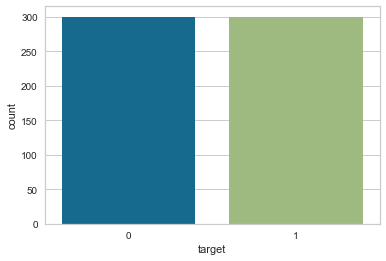

In [404]:
sns.countplot(y)

<Axes: >

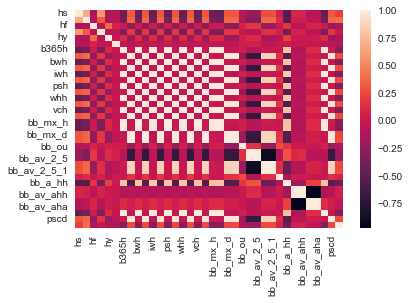

In [405]:
sns.heatmap(data.corr())

indicated as multicolinear

In [406]:
abs(data.corr()['target']).sort_values(ascending=False)[1:]

bb_a_hh        0.409673
hst            0.404691
iwh            0.320410
psch           0.319234
psh            0.312713
bb_av_h        0.309727
vch            0.307735
bwh            0.307491
whh            0.303591
b365h          0.303146
bb_mx_h        0.298787
bb_av_2_5_1    0.257839
iwd            0.256921
bb_mx_2_5_1    0.255355
whd            0.252662
bb_av_d        0.249135
bwd            0.247222
b365d          0.246322
vcd            0.245664
pscd           0.245553
psd            0.244675
bb_mx_d        0.244367
bb_av_2_5      0.208117
bb_mx_2_5      0.204625
hs             0.203025
hf             0.154112
hy             0.125226
bb_ou          0.123818
hr             0.121942
bb_ah          0.073200
bb_mx_ahh      0.055756
bb_av_ahh      0.045254
bb_av_aha      0.034883
bb_mx_aha      0.026466
hc             0.013607
Name: target, dtype: float64

In [407]:
cross_validation(data.iloc[:,:-1],y,HistGradientBoostingClassifier(random_state=0))

              precision    recall  f1-score   support

           0       0.64      0.67      0.66       100
           1       0.66      0.63      0.64       100

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.65      0.65      0.65       200

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       100
           1       0.71      0.61      0.66       100

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       100
           1       0.65      0.61      0.63       100

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.64      0.64      0.64       200



0.6559866436939509

In [408]:
cross_validation(data.iloc[:,:-1],y,RandomForestClassifier(random_state=0))

              precision    recall  f1-score   support

           0       0.66      0.67      0.66       100
           1       0.66      0.65      0.66       100

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.66      0.66      0.66       200

              precision    recall  f1-score   support

           0       0.63      0.77      0.69       100
           1       0.70      0.54      0.61       100

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200

              precision    recall  f1-score   support

           0       0.62      0.69      0.65       100
           1       0.65      0.57      0.61       100

    accuracy                           0.63       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.63      0.63      0.63       200



0.6463351365526364

In [409]:
cross_validation(data.iloc[:,:-1],y,GradientBoostingClassifier(random_state=0))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       100
           1       0.66      0.64      0.65       100

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200

              precision    recall  f1-score   support

           0       0.66      0.74      0.70       100
           1       0.70      0.62      0.66       100

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200

              precision    recall  f1-score   support

           0       0.69      0.66      0.67       100
           1       0.67      0.70      0.69       100

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200



0.6712127147086981

In [410]:
cross_validation(data.iloc[:,:-1],y,RandomForestClassifier(random_state=0))

              precision    recall  f1-score   support

           0       0.66      0.67      0.66       100
           1       0.66      0.65      0.66       100

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.66      0.66      0.66       200

              precision    recall  f1-score   support

           0       0.63      0.77      0.69       100
           1       0.70      0.54      0.61       100

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200

              precision    recall  f1-score   support

           0       0.62      0.69      0.65       100
           1       0.65      0.57      0.61       100

    accuracy                           0.63       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.63      0.63      0.63       200



0.6463351365526364

In [411]:
cross_validation(data.iloc[:,:-1],y,lightgbm.LGBMClassifier(random_state=0))

              precision    recall  f1-score   support

           0       0.64      0.69      0.67       100
           1       0.67      0.62      0.64       100

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       100
           1       0.70      0.61      0.65       100

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.67       200
weighted avg       0.68      0.68      0.67       200

              precision    recall  f1-score   support

           0       0.67      0.73      0.70       100
           1       0.70      0.64      0.67       100

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.68       200
weighted avg       0.69      0.69      0.68       200



0.6708529120877545

Data Engineered

In [412]:
int_cols

['hs', 'hst', 'hf', 'hc', 'hy', 'hr', 'bb_ou', 'bb_ah']

In [413]:
for col in int_cols:
  tmp_train = freq_encoding(data, col)
tmp_train

,hs,hst,hf,hc,hy,hr,b365h,b365d,bwh,bwd,...,pscd,target,hs_freq_encoded,hst_freq_encoded,hf_freq_encoded,hc_freq_encoded,hy_freq_encoded,hr_freq_encoded,bb_ou_freq_encoded,bb_ah_freq_encoded
id,,,,,,,,,,,,,,,,,,,,,
1,23,6,7,10,2,0,1.95,3.50,1.91,3.50,...,3.39,0,0.016667,0.108333,0.071667,0.075000,0.258333,0.955,0.070000,0.138333
2,21,5,5,8,1,0,1.28,6.50,1.26,6.00,...,5.25,0,0.025000,0.136667,0.045000,0.091667,0.301667,0.955,0.140000,0.218333
3,17,6,8,7,1,0,1.28,6.50,1.28,5.75,...,6.11,0,0.040000,0.108333,0.098333,0.108333,0.301667,0.955,0.146667,0.085000
4,26,11,12,6,1,0,1.90,3.79,1.83,3.75,...,3.56,0,0.005000,0.025000,0.111667,0.110000,0.301667,0.955,0.053333,0.200000
5,20,6,11,3,3,0,2.50,3.20,2.50,3.10,...,3.10,0,0.043333,0.108333,0.128333,0.113333,0.131667,0.955,0.161667,0.218333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,16,5,7,5,0,0,1.55,4.20,1.57,4.00,...,4.35,1,0.070000,0.136667,0.071667,0.143333,0.248333,0.955,0.146667,0.183333
597,21,12,5,7,1,0,1.16,8.50,1.16,7.50,...,9.75,1,0.025000,0.015000,0.045000,0.108333,0.301667,0.955,0.048333,0.183333
598,15,8,12,5,3,0,1.90,3.50,1.90,3.40,...,3.51,1,0.076667,0.056667,0.111667,0.143333,0.131667,0.955,0.053333,0.200000


In [414]:
tmp_train

,hs,hst,hf,hc,hy,hr,b365h,b365d,bwh,bwd,...,pscd,target,hs_freq_encoded,hst_freq_encoded,hf_freq_encoded,hc_freq_encoded,hy_freq_encoded,hr_freq_encoded,bb_ou_freq_encoded,bb_ah_freq_encoded
id,,,,,,,,,,,,,,,,,,,,,
1,23,6,7,10,2,0,1.95,3.50,1.91,3.50,...,3.39,0,0.016667,0.108333,0.071667,0.075000,0.258333,0.955,0.070000,0.138333
2,21,5,5,8,1,0,1.28,6.50,1.26,6.00,...,5.25,0,0.025000,0.136667,0.045000,0.091667,0.301667,0.955,0.140000,0.218333
3,17,6,8,7,1,0,1.28,6.50,1.28,5.75,...,6.11,0,0.040000,0.108333,0.098333,0.108333,0.301667,0.955,0.146667,0.085000
4,26,11,12,6,1,0,1.90,3.79,1.83,3.75,...,3.56,0,0.005000,0.025000,0.111667,0.110000,0.301667,0.955,0.053333,0.200000
5,20,6,11,3,3,0,2.50,3.20,2.50,3.10,...,3.10,0,0.043333,0.108333,0.128333,0.113333,0.131667,0.955,0.161667,0.218333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,16,5,7,5,0,0,1.55,4.20,1.57,4.00,...,4.35,1,0.070000,0.136667,0.071667,0.143333,0.248333,0.955,0.146667,0.183333
597,21,12,5,7,1,0,1.16,8.50,1.16,7.50,...,9.75,1,0.025000,0.015000,0.045000,0.108333,0.301667,0.955,0.048333,0.183333
598,15,8,12,5,3,0,1.90,3.50,1.90,3.40,...,3.51,1,0.076667,0.056667,0.111667,0.143333,0.131667,0.955,0.053333,0.200000


In [415]:
X = tmp_train.columns
X = [i for i in X if i != 'target']

In [416]:
cross_validation(tmp_train[X],y,RandomForestClassifier(random_state=0))

              precision    recall  f1-score   support

           0       0.66      0.73      0.70       100
           1       0.70      0.63      0.66       100

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200

              precision    recall  f1-score   support

           0       0.63      0.73      0.68       100
           1       0.68      0.57      0.62       100

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.65      0.65      0.65       200

              precision    recall  f1-score   support

           0       0.64      0.72      0.68       100
           1       0.68      0.60      0.64       100

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.66      0.66      0.66       200



0.6619050481085769

In [417]:
abs(tmp_train.corr()['target']).sort_values(ascending=False)[1:]

bb_a_hh               0.409673
hst                   0.404691
iwh                   0.320410
psch                  0.319234
psh                   0.312713
bb_av_h               0.309727
vch                   0.307735
bwh                   0.307491
whh                   0.303591
b365h                 0.303146
bb_mx_h               0.298787
bb_av_2_5_1           0.257839
iwd                   0.256921
bb_mx_2_5_1           0.255355
whd                   0.252662
bb_av_d               0.249135
bwd                   0.247222
b365d                 0.246322
vcd                   0.245664
pscd                  0.245553
psd                   0.244675
bb_mx_d               0.244367
hst_freq_encoded      0.208269
bb_av_2_5             0.208117
bb_mx_2_5             0.204625
hs                    0.203025
hf                    0.154112
hy                    0.125226
bb_ou                 0.123818
hr                    0.121942
hr_freq_encoded       0.120754
bb_ah                 0.073200
hy_freq_

In [418]:
tmp_train.drop_duplicates()

,hs,hst,hf,hc,hy,hr,b365h,b365d,bwh,bwd,...,pscd,target,hs_freq_encoded,hst_freq_encoded,hf_freq_encoded,hc_freq_encoded,hy_freq_encoded,hr_freq_encoded,bb_ou_freq_encoded,bb_ah_freq_encoded
id,,,,,,,,,,,,,,,,,,,,,
1,23,6,7,10,2,0,1.95,3.50,1.91,3.50,...,3.39,0,0.016667,0.108333,0.071667,0.075000,0.258333,0.955,0.070000,0.138333
2,21,5,5,8,1,0,1.28,6.50,1.26,6.00,...,5.25,0,0.025000,0.136667,0.045000,0.091667,0.301667,0.955,0.140000,0.218333
3,17,6,8,7,1,0,1.28,6.50,1.28,5.75,...,6.11,0,0.040000,0.108333,0.098333,0.108333,0.301667,0.955,0.146667,0.085000
4,26,11,12,6,1,0,1.90,3.79,1.83,3.75,...,3.56,0,0.005000,0.025000,0.111667,0.110000,0.301667,0.955,0.053333,0.200000
5,20,6,11,3,3,0,2.50,3.20,2.50,3.10,...,3.10,0,0.043333,0.108333,0.128333,0.113333,0.131667,0.955,0.161667,0.218333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,16,5,7,5,0,0,1.55,4.20,1.57,4.00,...,4.35,1,0.070000,0.136667,0.071667,0.143333,0.248333,0.955,0.146667,0.183333
597,21,12,5,7,1,0,1.16,8.50,1.16,7.50,...,9.75,1,0.025000,0.015000,0.045000,0.108333,0.301667,0.955,0.048333,0.183333
598,15,8,12,5,3,0,1.90,3.50,1.90,3.40,...,3.51,1,0.076667,0.056667,0.111667,0.143333,0.131667,0.955,0.053333,0.200000


In [419]:
# for i in float_cols:
#     for c in float_cols:
#         tmp_train[f'{c}_binding_encoded'] = pd.cut(tmp_train[c], bins=5, labels=[1,2,3,4,5])

In [420]:
X = [c for c in tmp_train.columns if c!="target"]
len(X)

43

In [421]:
cross_validation(tmp_train[X],y,RandomForestClassifier(random_state=0))

              precision    recall  f1-score   support

           0       0.66      0.73      0.70       100
           1       0.70      0.63      0.66       100

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200

              precision    recall  f1-score   support

           0       0.63      0.73      0.68       100
           1       0.68      0.57      0.62       100

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.65      0.65      0.65       200

              precision    recall  f1-score   support

           0       0.64      0.72      0.68       100
           1       0.68      0.60      0.64       100

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.66      0.66      0.66       200



0.6619050481085769

In [422]:
tmp_train

,hs,hst,hf,hc,hy,hr,b365h,b365d,bwh,bwd,...,pscd,target,hs_freq_encoded,hst_freq_encoded,hf_freq_encoded,hc_freq_encoded,hy_freq_encoded,hr_freq_encoded,bb_ou_freq_encoded,bb_ah_freq_encoded
id,,,,,,,,,,,,,,,,,,,,,
1,23,6,7,10,2,0,1.95,3.50,1.91,3.50,...,3.39,0,0.016667,0.108333,0.071667,0.075000,0.258333,0.955,0.070000,0.138333
2,21,5,5,8,1,0,1.28,6.50,1.26,6.00,...,5.25,0,0.025000,0.136667,0.045000,0.091667,0.301667,0.955,0.140000,0.218333
3,17,6,8,7,1,0,1.28,6.50,1.28,5.75,...,6.11,0,0.040000,0.108333,0.098333,0.108333,0.301667,0.955,0.146667,0.085000
4,26,11,12,6,1,0,1.90,3.79,1.83,3.75,...,3.56,0,0.005000,0.025000,0.111667,0.110000,0.301667,0.955,0.053333,0.200000
5,20,6,11,3,3,0,2.50,3.20,2.50,3.10,...,3.10,0,0.043333,0.108333,0.128333,0.113333,0.131667,0.955,0.161667,0.218333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,16,5,7,5,0,0,1.55,4.20,1.57,4.00,...,4.35,1,0.070000,0.136667,0.071667,0.143333,0.248333,0.955,0.146667,0.183333
597,21,12,5,7,1,0,1.16,8.50,1.16,7.50,...,9.75,1,0.025000,0.015000,0.045000,0.108333,0.301667,0.955,0.048333,0.183333
598,15,8,12,5,3,0,1.90,3.50,1.90,3.40,...,3.51,1,0.076667,0.056667,0.111667,0.143333,0.131667,0.955,0.053333,0.200000


In [423]:
tmp_train.columns

Index(['hs', 'hst', 'hf', 'hc', 'hy', 'hr', 'b365h', 'b365d', 'bwh', 'bwd',
       'iwh', 'iwd', 'psh', 'psd', 'whh', 'whd', 'vch', 'vcd', 'bb_mx_h',
       'bb_av_h', 'bb_mx_d', 'bb_av_d', 'bb_ou', 'bb_mx_2_5', 'bb_av_2_5',
       'bb_mx_2_5_1', 'bb_av_2_5_1', 'bb_ah', 'bb_a_hh', 'bb_mx_ahh',
       'bb_av_ahh', 'bb_mx_aha', 'bb_av_aha', 'psch', 'pscd', 'target',
       'hs_freq_encoded', 'hst_freq_encoded', 'hf_freq_encoded',
       'hc_freq_encoded', 'hy_freq_encoded', 'hr_freq_encoded',
       'bb_ou_freq_encoded', 'bb_ah_freq_encoded'],
      dtype='object')

In [424]:
abs(tmp_train.corr()['target']).sort_values(ascending=False)[1:]

bb_a_hh               0.409673
hst                   0.404691
iwh                   0.320410
psch                  0.319234
psh                   0.312713
bb_av_h               0.309727
vch                   0.307735
bwh                   0.307491
whh                   0.303591
b365h                 0.303146
bb_mx_h               0.298787
bb_av_2_5_1           0.257839
iwd                   0.256921
bb_mx_2_5_1           0.255355
whd                   0.252662
bb_av_d               0.249135
bwd                   0.247222
b365d                 0.246322
vcd                   0.245664
pscd                  0.245553
psd                   0.244675
bb_mx_d               0.244367
hst_freq_encoded      0.208269
bb_av_2_5             0.208117
bb_mx_2_5             0.204625
hs                    0.203025
hf                    0.154112
hy                    0.125226
bb_ou                 0.123818
hr                    0.121942
hr_freq_encoded       0.120754
bb_ah                 0.073200
hy_freq_

In [425]:
exp_name = setup(data = tmp_train,  target = 'target')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:11:54
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7619,0.8662,0.6667,0.8235,0.7368,0.5238,0.5336
1,0.7857,0.8231,0.8571,0.7500,0.8000,0.5714,0.5774
2,0.7857,0.8934,0.8571,0.7500,0.8000,0.5714,0.5774
3,0.6905,0.6893,0.6667,0.7000,0.6829,0.3810,0.3814
4,0.6190,0.7392,0.6190,0.6190,0.6190,0.2381,0.2381
5,0.7143,0.7937,0.6667,0.7368,0.7000,0.4286,0.4305
6,0.7143,0.8095,0.5714,0.8000,0.6667,0.4286,0.4472
7,0.6667,0.7347,0.6190,0.6842,0.6500,0.3333,0.3349
8,0.6667,0.7642,0.8095,0.6296,0.7083,0.3333,0.3478


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:11:57
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7619,0.8685,0.6667,0.8235,0.7368,0.5238,0.5336
1,0.7857,0.8141,0.8571,0.7500,0.8000,0.5714,0.5774
2,0.8333,0.9070,0.8571,0.8182,0.8372,0.6667,0.6674
3,0.6667,0.6961,0.6190,0.6842,0.6500,0.3333,0.3349
4,0.6667,0.7596,0.6667,0.6667,0.6667,0.3333,0.3333
5,0.7143,0.7846,0.6667,0.7368,0.7000,0.4286,0.4305
6,0.7381,0.8118,0.6190,0.8125,0.7027,0.4762,0.4903
7,0.6905,0.7392,0.6190,0.7222,0.6667,0.3810,0.3849
8,0.6667,0.7732,0.8095,0.6296,0.7083,0.3333,0.3478


Fitting 10 folds for each of 10 candidates, totalling 100 fits


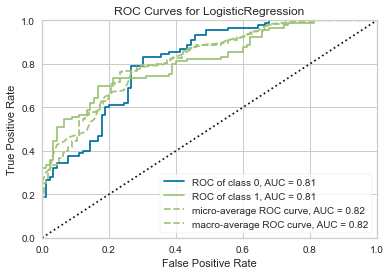

In [426]:
lr = create_model('lr')
tuned_lr = tune_model(lr)
plot_model(tuned_lr,plot = 'auc')

In [427]:
dt = create_model('dt')
tuned_dt = tune_model(dt)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:12:21
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5476,0.5476,0.6667,0.5385,0.5957,0.0952,0.0981
1,0.5238,0.5238,0.6190,0.5200,0.5652,0.0476,0.0485
2,0.6905,0.6905,0.7619,0.6667,0.7111,0.3810,0.3849
3,0.5952,0.5952,0.6190,0.5909,0.6047,0.1905,0.1907
4,0.5714,0.5714,0.6190,0.5652,0.5909,0.1429,0.1435
5,0.6190,0.6190,0.5714,0.6316,0.6000,0.2381,0.2392
6,0.5000,0.5000,0.4762,0.5000,0.4878,0.0000,0.0000
7,0.5476,0.5476,0.6190,0.5417,0.5778,0.0952,0.0962
8,0.5952,0.5952,0.6667,0.5833,0.6222,0.1905,0.1925


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:12:23
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Decision Tree Classifier


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [429]:
top = compare_models(n_select = 3)
blender = blend_models(top)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:13:45
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7619,0.0000,0.6667,0.8235,0.7368,0.5238,0.5336
1,0.7619,0.0000,0.8095,0.7391,0.7727,0.5238,0.5262
2,0.8095,0.0000,0.8571,0.7826,0.8182,0.6190,0.6219
3,0.6429,0.0000,0.5714,0.6667,0.6154,0.2857,0.2887
4,0.6429,0.0000,0.6667,0.6364,0.6512,0.2857,0.2860
5,0.6905,0.0000,0.6190,0.7222,0.6667,0.3810,0.3849
6,0.7381,0.0000,0.6190,0.8125,0.7027,0.4762,0.4903
7,0.6429,0.0000,0.5714,0.6667,0.6154,0.2857,0.2887
8,0.6905,0.0000,0.7619,0.6667,0.7111,0.3810,0.3849


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:14:22
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7619,0.0000,0.6667,0.8235,0.7368,0.5238,0.5336
1,0.7619,0.0000,0.8095,0.7391,0.7727,0.5238,0.5262
2,0.8095,0.0000,0.8571,0.7826,0.8182,0.6190,0.6219
3,0.6429,0.0000,0.5714,0.6667,0.6154,0.2857,0.2887
4,0.6429,0.0000,0.6667,0.6364,0.6512,0.2857,0.2860
5,0.6905,0.0000,0.6190,0.7222,0.6667,0.3810,0.3849
6,0.7381,0.0000,0.6190,0.8125,0.7027,0.4762,0.4903
7,0.6429,0.0000,0.5714,0.6667,0.6154,0.2857,0.2887
8,0.6905,0.0000,0.7619,0.6667,0.7111,0.3810,0.3849
